In [8]:
from tqdm import tqdm
import pandas as pd
import torchaudio
import librosa
import shutil
import json
import os

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=8, progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
audio_dir = "/data/audio_data/prep_submission_audio/12/"

metadata_path = "../prep_data/raw_jsonl/info_out_domain_short_sentence_testset.jsonl"
with open(metadata_path, "r", encoding="utf-8") as f:
    content = f.readlines()
    lines = [json.loads(line.strip()) for line in content]
    data = pd.DataFrame(lines)
    
data["audio_path"] = data.id.apply(lambda x: os.path.join(audio_dir, f'{x}.wav'))
print(data.shape)
data.head(2)

(73817, 13)


,id,raw,text,utt_id,start_time,end_time,arpas,trans,phone_scores,word_scores,word_ids,utterance_scores,audio_path
0,5580017,waitress,WAITRESS,None,None,None,"[W, EY1, T, R, AH0, S]","[W, EY, T, R, SCHWA, S]","[98, 99, 95, 98, 92, 91]",[96],"[0, 0, 0, 0, 0, 0]",96.0,/data/audio_data/prep_submission_audio/12/5580...
1,5580020,director,DIRECTOR,None,None,None,"[D, IH0, R, EH1, K, T, ER0]","[D, IH, R, EH, K, T, ER]","[97, 98, 95, 84, 35, 71, 82]",[79],"[0, 0, 0, 0, 0, 0, 0]",79.0,/data/audio_data/prep_submission_audio/12/5580...


In [10]:
def check_audio(path, min_duration=1.0):    
    try:
        wav, sr = librosa.load(path, sr=16000)   

        if wav.shape[0] / sr < min_duration:
            return False 
    except:
        return False
    
    return True
    
is_success = data.parallel_apply(lambda x: check_audio(x["audio_path"]), axis=1)
print(is_success[is_success==False].shape)
print(is_success[is_success==True].shape)

(0,)
(73817,)


In [11]:
data = data[is_success==True]

<Axes: >

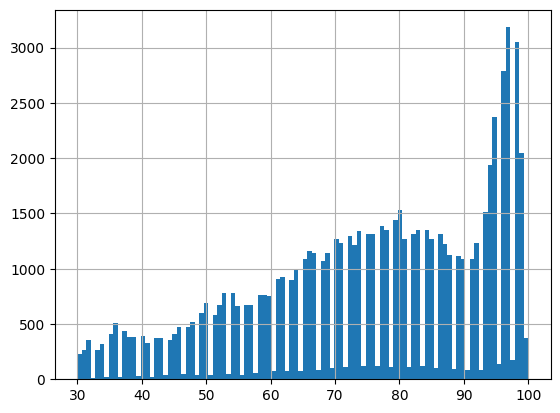

In [12]:
data.utterance_scores.hist(bins=100)

In [13]:
data[["id", "text"]].to_csv("../prep_data/csv/info_out_domain_short_sentence_testset.csv", sep="|", index=None, header=None)

In [14]:
extracted_data = data[is_success == True]
path = "../prep_data/jsonl/info_out_domain_short_sentence_testset.jsonl"
with open(path, "w", encoding="utf-8") as f:
    for index in tqdm(extracted_data.index):
        sample = extracted_data.loc[index].to_dict()
        json_obj = json.dumps(sample)

        f.write(f'{json_obj}\n')

  4%|▍         | 2905/73817 [00:00<00:02, 29047.05it/s]

100%|██████████| 73817/73817 [00:02<00:00, 29241.57it/s]
